### EDA and Forecasting of Superstore Sales

This notebook presents my first structured exploration of time series forecasting. Using monthly sales data, I experiment with several classical and automated forecasting models, including Theta, SARIMA, and Prophet, to evaluate their predictive performance and understand how different techniques handle trend and seasonality.

The goal of this work is both exploratory and educational to build intuition around time series behavior, compare model performance through standard evaluation metrics, and lay the groundwork for more advanced forecasting solutions in future projects.

#### Install and Import Libraries

In [146]:
!pip install kagglehub --q
!pip install seaborn   --q
!pip install statsmodels --q
!pip install sktime --q
!pip install pmdarima --q
!pip install prophet --quiet


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip

[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [174]:
import kagglehub
import shutil
import os
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
import pandas as pd
from sktime.utils.plotting import plot_series
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

#### Download Dataset

We download the dataset we'll be using from kaggle using the `kagglehub` library

In [32]:
path = kagglehub.dataset_download("rohitsahoo/sales-forecasting")

Since this method by default downloads files to an internal KaggleHub cache location, we'll copy them to our current location. 

In [33]:
destination = os.path.join(os.getcwd(), "./data")
os.makedirs(destination, exist_ok=True)

for filename in os.listdir(path):
    src_file = os.path.join(path, filename)
    dst_file = os.path.join(destination, filename)
    shutil.copy(src_file, dst_file)

We now read the dataset with `pandas` and we can take a look and start exploring the different fields.

In [34]:
df = pd.read_csv(os.path.join(destination, "train.csv"))
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96


#### Data Exploration and Cleaning

##### Preprocessing

We'll drop some irrelevant or low-impact columns for sales forecasting. These include identifiers and granular personal data that do not contribute significantly to the forecasting task.

We'll also convert the format of `Order Date` and `Ship Date` to standard datetime formats.

In [35]:
columns_to_drop = [
    'Row ID', 'Order ID', 'Ship Mode', 'Customer ID',
    'Customer Name', 'Product ID', 'Postal Code', 'Country'
    ]

df.drop(columns=columns_to_drop, inplace=True)

df['Order Date'] = pd.to_datetime(df['Order Date'], format="%d/%m/%Y")
df['Ship Date']  = pd.to_datetime(df['Ship Date'], format="%d/%m/%Y")

Now `df` is the dataframe that contains all the information about sales from a superstore in the United States, registering for each sale the date when it was ordered (`Order Date`) among other related data.

In [36]:
df.head(5)

,Order Date,Ship Date,Segment,City,State,Region,Category,Sub-Category,Product Name,Sales
0,2017-11-08,2017-11-11,Consumer,Henderson,Kentucky,South,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2017-11-08,2017-11-11,Consumer,Henderson,Kentucky,South,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,2017-06-12,2017-06-16,Corporate,Los Angeles,California,West,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,2016-10-11,2016-10-18,Consumer,Fort Lauderdale,Florida,South,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,2016-10-11,2016-10-18,Consumer,Fort Lauderdale,Florida,South,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


We will create separate datasets for each region to identify the sales trends on each (if any).

In [37]:
central = df[df['Region'] == 'Central']
east    = df[df['Region'] == 'East']
south   = df[df['Region'] == 'South']
west    = df[df['Region'] == 'West']

We now make the necessary convertions so we have an overall monthly sales df and also by region monthly sales df.

To achieve this we group `Sales` by `Order Date`, then sort according to `Order Date` and finally resample this same column so it's in year-month format.

In [38]:
all_daily   = df.groupby('Order Date')['Sales'].sum().reset_index()
all_daily   = all_daily.sort_values('Order Date')
all_monthly = all_daily.set_index('Order Date').resample('ME').mean()

central_daily   = central.groupby('Order Date')['Sales'].sum().reset_index()
central_daily   = central_daily.sort_values('Order Date')
central_monthly = central_daily.set_index('Order Date').resample('ME').mean()

east_daily   = east.groupby('Order Date')['Sales'].sum().reset_index()
east_daily   = east_daily.sort_values('Order Date')
east_monthly = east_daily.set_index('Order Date').resample('ME').mean()

south_daily   = south.groupby('Order Date')['Sales'].sum().reset_index()
south_daily   = south_daily.sort_values('Order Date')
south_monthly = south_daily.set_index('Order Date').resample('ME').mean()

west_daily   = west.groupby('Order Date')['Sales'].sum().reset_index()
west_daily   = west_daily.sort_values('Order Date')
west_monthly = west_daily.set_index('Order Date').resample('ME').mean()

##### Descriptive Statistics

We'll use the `describe` method from pandas to retrieve a summary statistic that describes our dataset a little bit, including **mean** (measure of central tendency), **standard deviation** (measure of dispersion), **percentiles** and **maximum** and **minimum** of the distribution.

In [39]:
all_monthly.describe()

,Sales
count,48.000000
mean,1775.061941
std,812.454746
min,225.994600
25%,1124.826076
50%,1539.262281
75%,2443.701486
max,3931.271833


##### Time Plot

Daily.

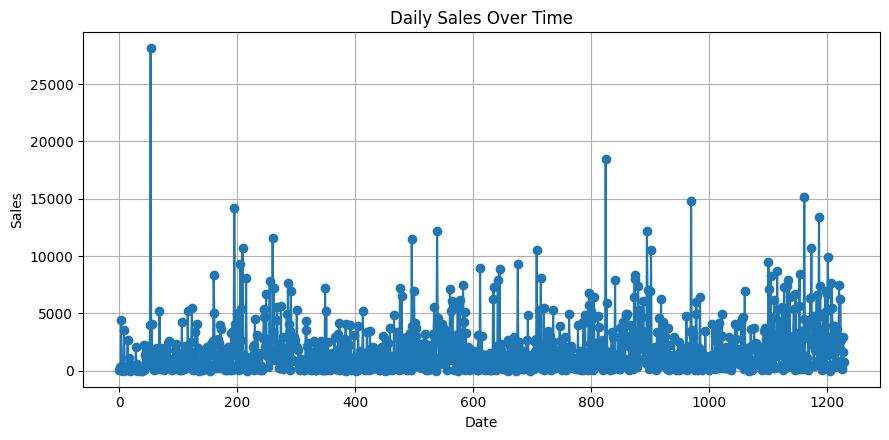

In [40]:
plt.figure(figsize=(9, 4.5))
plt.plot(all_daily.index, all_daily['Sales'], marker='o')
plt.title('Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

Monthly. This plot itself provides several information! As we could expect, the pattern shows some yearly seasonality and an increasing trend over the years.

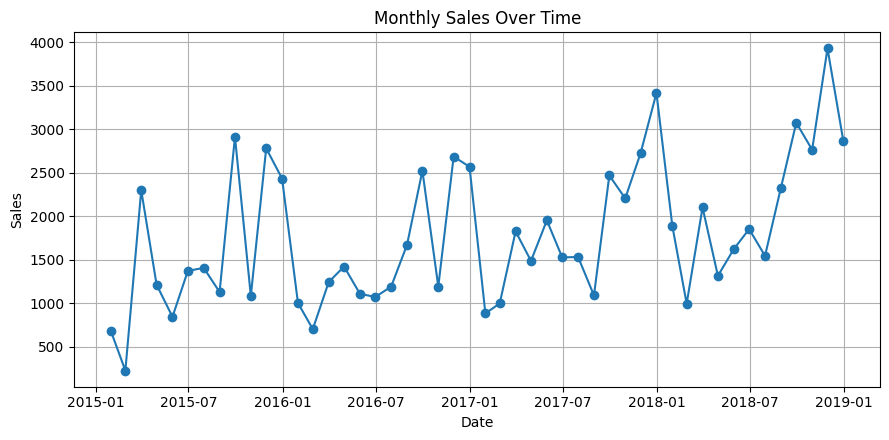

In [41]:
plt.figure(figsize=(9, 4.5))
plt.plot(all_monthly.index, all_monthly['Sales'], marker='o')
plt.title('Monthly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.grid(True)
plt.show()

Yearly. This plot shows us an evident increasing trend.

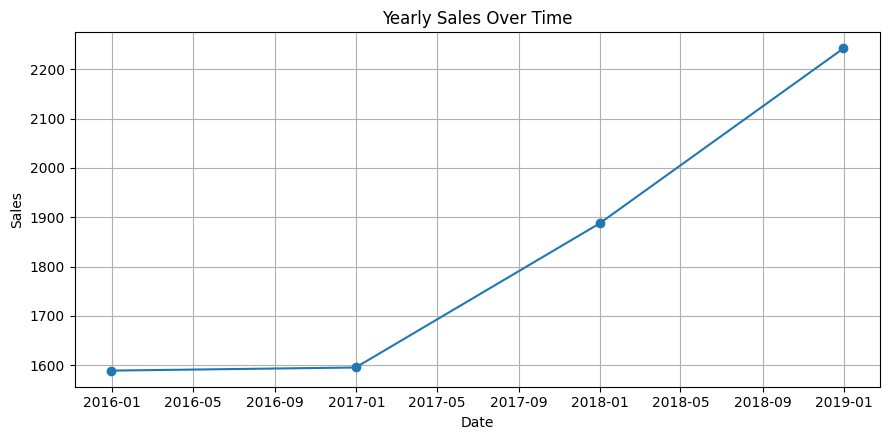

In [42]:
all_yearly = all_daily.set_index('Order Date').resample('YE').mean()

plt.figure(figsize=(9, 4.5))
plt.plot(all_yearly.index, all_yearly['Sales'], marker='o')
plt.title('Yearly Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.grid(True)
plt.show()

To make it more interesting, we'll also take a look into the monthly sales by region!

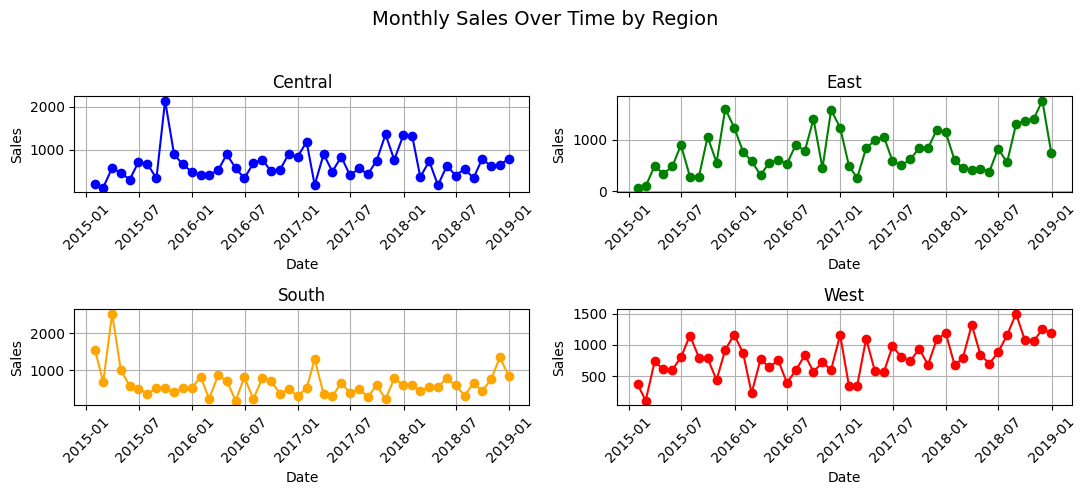

In [43]:
fig, axs = plt.subplots(2, 2, figsize=(11, 5))
fig.suptitle('Monthly Sales Over Time by Region', fontsize=14)

axs[0, 0].plot(central_monthly.index, central_monthly['Sales'], color='blue', marker='o')
axs[0, 0].set_title('Central')
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Sales')
axs[0, 0].grid(True)

axs[0, 1].plot(east_monthly.index, east_monthly['Sales'], color='green', marker='o')
axs[0, 1].set_title('East')
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Sales')
axs[0, 1].grid(True)

axs[1, 0].plot(south_monthly.index, south_monthly['Sales'], color='orange', marker='o')
axs[1, 0].set_title('South')
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Sales')
axs[1, 0].grid(True)

axs[1, 1].plot(west_monthly.index, west_monthly['Sales'], color='red', marker='o')
axs[1, 1].set_title('West')
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Sales')
axs[1, 1].grid(True)

for ax in axs.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

##### Seasonal Decomposition

As time series data can exhibit various of patterns, it's quite helpful to split a time series into components, each representing an underlying pattern category.

We'll use `seasonal_decompose` from statsmodel library, which allow us to split a time series in three components: **trend**, **seasonal** and **remainder** components.

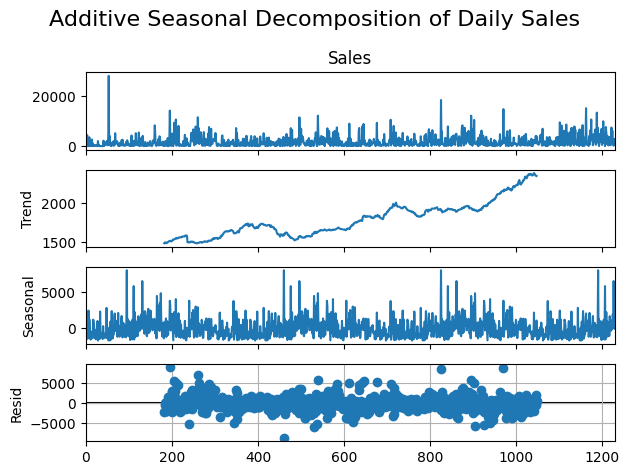

In [44]:
result = seasonal_decompose(all_daily['Sales'], model='additive', period=365)
result.plot()
plt.suptitle('Additive Seasonal Decomposition of Daily Sales', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

Monthly. Here we can see a strong seasonal component, not observed on the daily and yearly decompositions, as well as a growing trend (across daily, monthly and yearly).

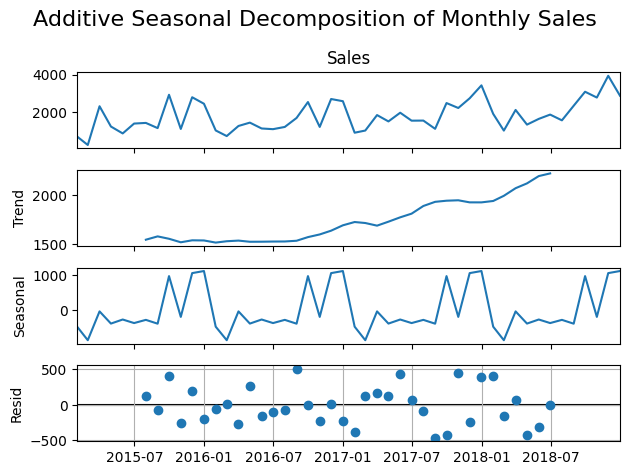

In [45]:
result = seasonal_decompose(all_monthly['Sales'], model='additive')
result.plot()
plt.suptitle('Additive Seasonal Decomposition of Monthly Sales', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

Yearly.

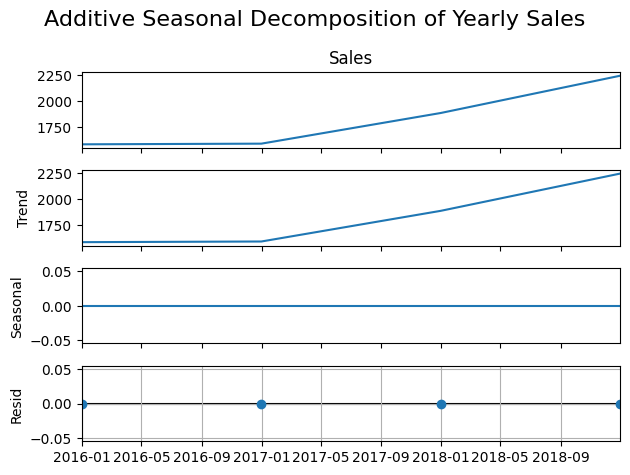

In [46]:
result = seasonal_decompose(all_yearly['Sales'], model='additive')
result.plot()
plt.suptitle('Additive Seasonal Decomposition of Yearly Sales', fontsize=16)
plt.tight_layout()
plt.grid(True)
plt.show()

#### Forecasting

##### Theta Forecaster

We take the `Sales` column of the all_monthly dataframe, and then change the index so it is in a monthly PeriodIndex format starting on January 2014. This is needed so that the sktime forecasting model we are using understands the data and applies the seasonality correctly.

In [47]:
y = all_monthly['Sales']
y.index = pd.period_range(start='2014-01', periods=len(y), freq='M')

We split the time series in training (`y_train`) and testing (`y_test`), respecting the temporal order and not at random (or some kind of random) like ML and DL, and also define the "forecasting horizon", which is the dates we want to predict sales for, this being the ones on `y_test`. 

In [48]:
y_train, y_test = temporal_train_test_split(y)
horizon = ForecastingHorizon(y_test.index, is_relative=False)

In [140]:
len(y_train)

36

We create an instance of the Theta Forecaster model, and we use a seasonality of 12 periods (months) and then train it using the training data, which allows the model to learn the trend and seasonal pattern. After this, we make predictions for the forecasting horizon and lastly plot the full time series and the prediction to see how did the model do.

In [144]:
forecasting_model = ThetaForecaster(sp=12)
forecasting_model.fit(y_train)
y_pred = forecasting_model.predict(horizon)

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Theta Forecast'}, ylabel='Sales'>)

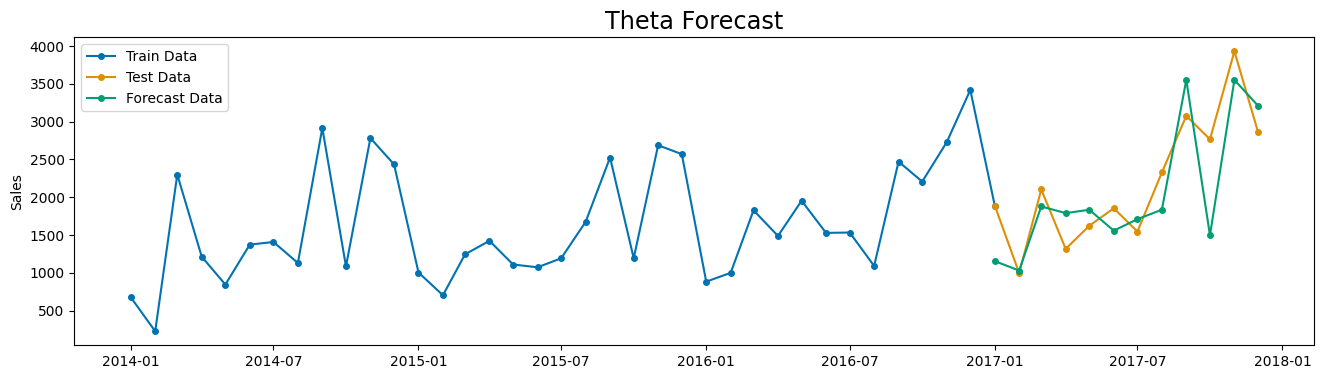

In [145]:
labels=['Train Data', 'Test Data', 'Forecast Data']
plot_series(y[:37], y_test, y_pred, labels=labels, title='Theta Forecast')

We also calculate some metrics to have a cuantitative notion besides the plot itself.

In [50]:
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape*100:.2f}%")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE : {mae:.2f}")
r2 = r2_score(y_test, y_pred)   
print(f"R2  : {r2:.2f}")

MAPE: 19.40%
MAE : 425.17
R2  : 0.57


The Theta Forecaster achieved a moderate forecasting performance on the monthly sales data we used. With a MAPE of 19.40%, the model's predictions deviate by about 19% from the actual values on average, which is sort of acceptable given the high variability observed in the dataset.

The MAE of 425.17 indicates that, in absolute terms, predictions are off by around 425 on average, 23.9% of the average monthly sales (1775 according to `describe()` pandas function).

Additionally, the model explains 57% of the variance (coefficient of determination R² = 0.57) in the sales series, which suggests that it captures some meaningful patterns, though a significant portion of variability remains unexplained.

Given the relatively high standard deviation and wide sales range, the current results are a reasonable starting point. However, there's clear room for improvement, possibly through the use of more advanced models, which we'll do in the following sections.

##### ARIMA

ARIMA (Auto Regressive Integrated Moving Average) is a generalization of an ARMA (Auto Regressive Moving Average) and is fitted to time-series data in an effort to forecast future points. ARIMA models can be especially efficacious in cases where data shows evidence of non-stationarity ([pmdarima library](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.ARIMA.html)).

* AR indicates that the evolving variable of interest is regressed on its own lagged (i.e., prior observed) values.

* I indicates that the data values have been replaced with the difference between their values and the previous values.

* MA indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past.

We first need to ensure that the series we're working with is stationary, which involves checking if its statistical properties such as mean, variance, and autocorrelation are constant over time.

We'll first use the Augmented Dickey-Fuller (ADF) test to check for stationarity, since ARIMA works well for stationary time series. A p-value below 0.05 indicates stationarity, and our data meets this criterion! Because of this we'll use SARIMA (Stationary ARIMA), an extension of ARIMA that includes an additional component to manage seasonality.

In [86]:
adf = adfuller(all_monthly['Sales'])
print('ADF Statistic: %f' % adf[0])
print('p-value: %f' % adf[1])

ADF Statistic: -4.693579
p-value: 0.000087


We now use the Autocorrelation Function (ACF) plot, that shows the correlation of a time series with itself at different lags, and the Partial Autocorrelation Function (PACF) plot, that shows the correlation of a time series with itself at different lags, after removing the effects of the previous lags, **to find the SARIMA parameters**.

A SARIMA model is an extension of ARIMA that accounts for seasonal patterns and is defined by two sets of parameters **(p, d, q) × (P, D, Q, s)**

* p: the number of autoregressive (AR) terms. This represents the influence of past values on the current value.

* d: the number of differencing operations needed to make the series stationary.

* q: the number of moving average (MA) terms. This reflects the influence of past forecast errors on the current value.

* P: number of seasonal autoregressive terms.

* D: number of seasonal differencing operations.

* Q: number of seasonal moving average terms.

* s: the seasonal period, e.g., 12 for our monthly data with yearly seasonality.

These parameters are chosen by analyzing patterns in the ACF and PACF plots, both for regular and seasonal lags, but **can be fine-tuned iteratively to improve forecasting performance**.

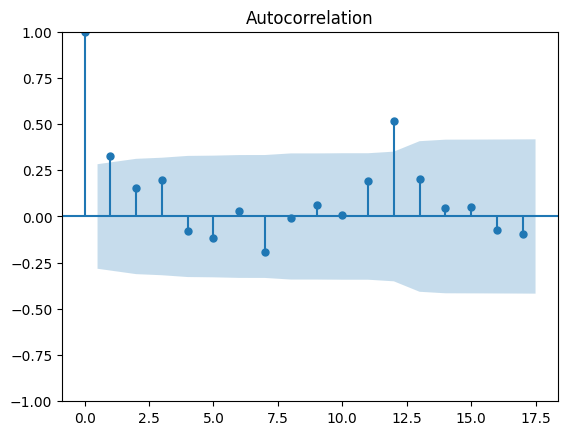

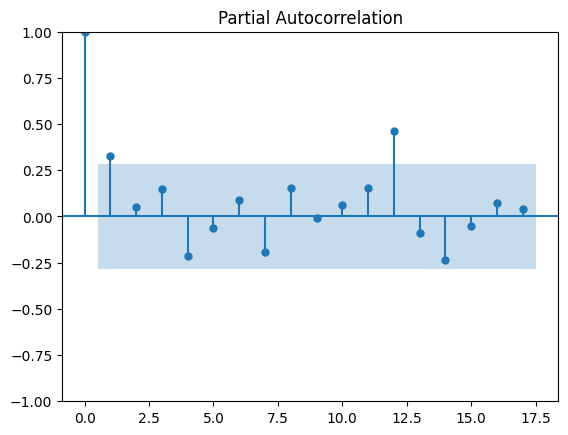

In [87]:
plot_acf(all_monthly['Sales'])
plot_pacf(all_monthly['Sales'])
plt.show()

To determine these parameters, we performed a stationarity test (Augmented Dickey-Fuller test), and the resulting p-value was below 0.05, indicating that the data is already stationary. Therefore, we set `d = 0`. We then used the previous plots for guidance:

* PACF is useful for determining p. A significant spike at lag 1 suggests an `p = 1` (AR component).

* ACF is useful for determining q. A significant spike at lag 1 suggests an `q = 1` (MA component).

The seasonal order was selected based on visual inspection of the time series and its autocorrelation (ACF) and partial autocorrelation (PACF) plots.

* The seasonal differencing `D=1` suggests the presence of annual seasonality in monthly data, as the original series showed strong recurring patterns every 12 periods.

* No seasonal AR term `P=0` was necessary as no strong correlation at seasonal lags appeared in the PACF plot.

* The seasonal moving average component was set to `Q=0` after observing that including it in the model (Q=1) produced warnings indicating insufficient data to estimate seasonal parameters reliably. This suggested that the dataset did not provide enough seasonal cycles to support estimation of this parameter.

* Since we are working with monthly values and we observed a seasonality every 12 periods `s=12`

Based on the observed patterns, a reasonable starting point could be `(1, 0, 1) x (0, 1, 0, 12)`. Still, it is very important to note that **model selection is iterative**. Other configurations may also be considered and compared to identify the one that best suits our data.

We now build the SARIMA model, and train it to then forecast. We'll define our train and test groups. In our case we'll be predicting the last 12 months, so we split accordingly.

Note that we use `SARIMAX` but since the default value `exog=None`, if we don't specify exogenous regressors, it is a SARIMA model, not SARIMAX. In the same line, if we don't specify the seasonal order, its by default `seasonal_order=(0,0,0,0)` which makes the model traditional ARIMA.

In [134]:
train = all_monthly[:-12]
test  = all_monthly[-13:]

model    = SARIMAX(train, order=(1,0,1), seasonal_order=(0, 1, 0, 12))
results  = model.fit()
forecast = results.forecast(steps=12)

new_point_forecast = pd.Series([results.fittedvalues.values[-1]], index=[pd.to_datetime(results.fittedvalues.index[-1])])
forecast           = pd.concat([new_point_forecast, forecast])

We now plot the full time series and the prediction to see how did the model do.

(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'SARIMA Forecast'}, ylabel='Sales'>)

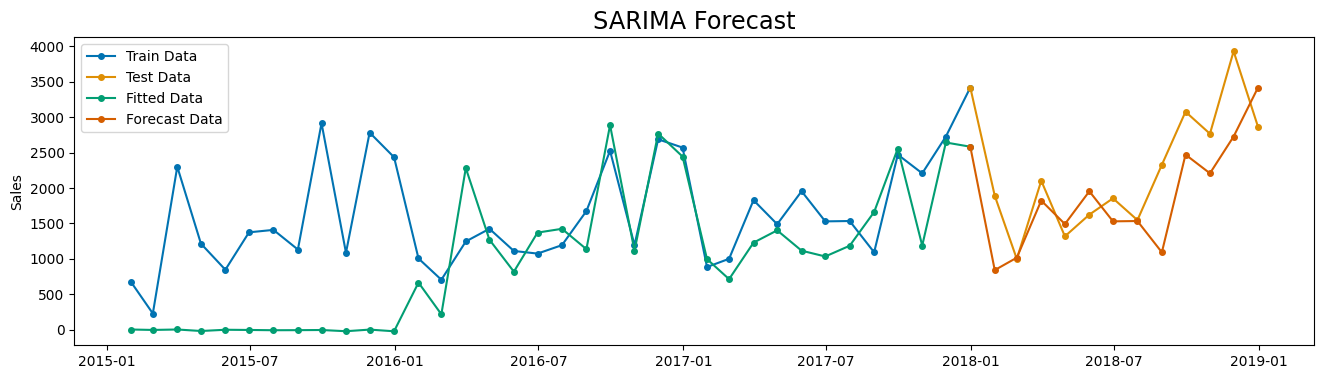

In [135]:
labels=['Train Data', 'Test Data', 'Fitted Data', 'Forecast Data']
plot_series(train['Sales'], test['Sales'], results.fittedvalues, forecast, labels=labels, title='SARIMA Forecast')

We also calculate some metrics to have a cuantitative notion besides the plot itself.

In [137]:
mape = mean_absolute_percentage_error(test, forecast)
print(f"MAPE: {mape*100:.2f}%")
mae = mean_absolute_error(test, forecast)
print(f"MAE : {mae:.2f}")
r2 = r2_score(test, forecast)   
print(f"R2  : {r2:.2f}")

MAPE: 22.33%
MAE : 553.14
R2  : 0.33


The SARIMA model yielded a somewhat weaker forecasting performance compared to the previously evaluated Theta Forecaster. Specifically, the MAPE was 22.33%, suggesting that the model's predictions deviate by over 22% from the actual values on average — a notable increase in error compared to the 19.40% achieved by the Theta model.

In terms of MAE, SARIMA also underperformed with an average error of 553.14, which is approximately 31.2% of the average monthly sales (1775), up from 23.9% in the Theta model. This suggests that, on average, SARIMA’s predictions were more off target in absolute terms.

Perhaps most strikingly, the coefficient of determination (R²) dropped to 0.33, indicating that SARIMA could only explain about 33% of the variance in the sales data. This is considerably lower than the 57% explained variance by the Theta model, and it implies that SARIMA is capturing less of the underlying structure in the series.

These results might seem counterintuitive, especially considering that SARIMA is designed to model seasonal data explicitly. However, there are a few potential reasons for this outcome:

* Parameter tuning: If the seasonal parameters were not well tuned or if the seasonality in the data isn't strong or consistent, SARIMA might fail to capture useful patterns. In my case I went on with some starting values and did not perform fine-tuning over the parameters.

* Noise and irregularities: If the dataset has high variability or sudden spikes or drops not tied to regular seasonality, models like Theta which combine trend smoothing and extrapolation might handle them better.

In summary, while SARIMA is theoretically well-suited for data with seasonal components, its performance in this case was inferior to the simpler Theta model, possibly due to inconsistent or weak seasonality in the dataset, or suboptimal parameter selection (my guess!). These findings highlight the importance of not assuming more complex models always outperform simpler ones, and understand the complexity that it implies.

##### Prophet

We create our train and test splits, we want to predict the last 12 months.

In [ ]:
df = all_monthly.reset_index()  
df.columns = ['ds', 'y']

train = df[:-12]
test  = df[-13:]

We create an instance of the Prophet forecasting model, train it using the training data, and then we make predictions for 12 periods (months to forecast forward) and lastly plot the full time series and the prediction to see how did the model do.

In [ ]:
prophet_model = Prophet()
prophet_model.fit(train)

prediction = prophet_model.make_future_dataframe(periods=12, freq='M')
forecast   = prophet_model.predict(prediction)

16:11:17 - cmdstanpy - INFO - Chain [1] start processing
16:11:18 - cmdstanpy - INFO - Chain [1] done processing
c:\Users\csier\OneDrive\Escritorio\TT\Labs\.venv\Lib\site-packages\prophet\forecaster.py:1854: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


(<Figure size 1600x400 with 1 Axes>,
 <Axes: title={'center': 'Prophet Forecast'}, ylabel='y'>)

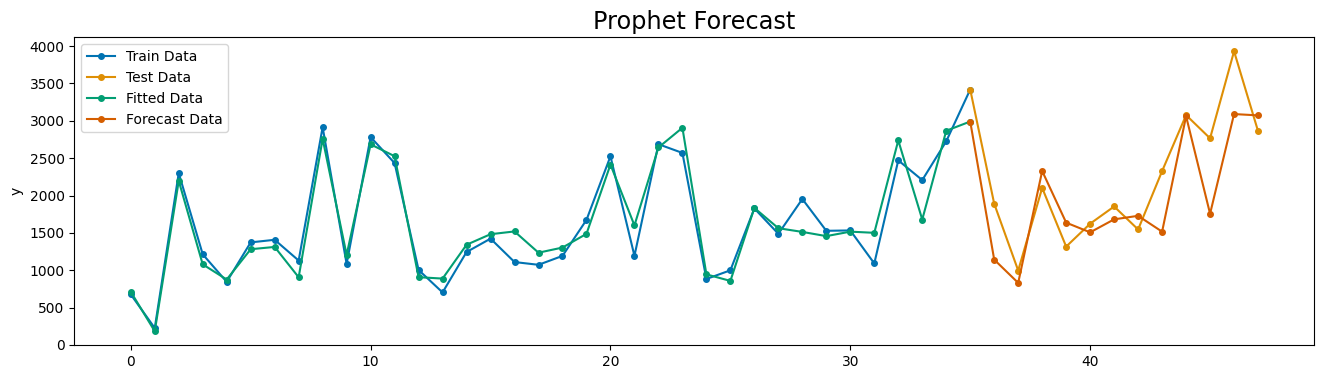

In [163]:
labels=['Train Data', 'Test Data', 'Fitted Data', 'Forecast Data']
plot_series(train['y'], test['y'], forecast['yhat'][:-12], forecast['yhat'][-13:], labels=labels, title='Prophet Forecast')

We also calculate some metrics to have a cuantitative notion besides the plot itself.

In [173]:
y_true = test['y']
y_pred = forecast['yhat'][-13:] 

mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"MAPE: {mape*100:.2f}%")
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE : {mae:.2f}")
r2 = r2_score(y_true, y_pred)   
print(f"R2  : {r2:.2f}")

MAPE: 17.90%
MAE : 403.55
R2  : 0.63


The Prophet model delivered the strongest performance among the three forecasting approaches evaluated (Theta and SARIMA). With a MAPE of 17.90%, its predictions deviated the least from the actual values on average, outperforming both Theta (19.40%) and SARIMA (22.33%). It also achieved the lowest MAE (403.55), indicating a smaller average absolute error. The R² score of 0.63 shows that Prophet was able to explain 63% of the variance in the sales data, capturing meaningful underlying patterns.

These results are encouraging, particularly considering Prophet’s strength in automatically modeling trend and seasonality — which seems to have aligned well with the characteristics of this dataset, despite its variability and limited seasonal structure.

**It’s important to note that this notebook reflects my first structured exploration of forecasting, so there’s significant room for improvement in both model tuning and evaluation strategies. Future iterations could benefit from more thorough hyperparameter optimization, the inclusion of external regressors, or experimentation with more models.**